<a href="https://colab.research.google.com/github/dentadelta/123/blob/master/Finetune_mdetr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
#Install the required library package
%%capture
!pip install timm transformers
!git clone https://github.com/ashkamath/mdetr.git

#Load the library
import os
os.chdir('/content/mdetr')
import torch
from hubconf import PositionEmbeddingSine
from models.mdetr import MDETR, SetCriterion, ContrastiveCriterion, QACriterionGQA
from models.matcher import HungarianMatcher
from timm.models import create_model
from models.backbone import Joiner, replace_bn ,OrderedDict,NestedTensor
from models.transformer import Transformer
from models.position_encoding import build_position_encoding
from PIL import Image
import requests
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

1.0 Save the pretrained model somewhere to train offline or train on computer with no access to the internet

In [4]:
pretrained_model_path = '/content/EB5_checkpoint.pth'   #Change this to where you want to save your model
backbone_model_path = '/content/backbone.pth'   #Change this to where you want to save your model
checkpoint = torch.hub.load_state_dict_from_url(url="https://zenodo.org/record/4721981/files/pretrained_EB5_checkpoint.pth",map_location="cpu",check_hash=True)  #Download the data
torch.save(checkpoint,pretrained_model_path) #Save the data
backbone = create_model("tf_efficientnet_b5_ns", pretrained=True, in_chans=3, features_only=True, out_indices=(1, 2, 3, 4)) #Download the backbone
torch.save(backbone.state_dict(),backbone_model_path) #Save the backbone

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b5_ns-6f26d0cf.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b5_ns-6f26d0cf.pth


2.0 Copy the pretrained models to your offline computer

3.0 Load the model on your offline computer

In [2]:
pretrained_model_path_on_offline_computer = '/content/EB5_checkpoint.pth'  #Change this to suit
pretrained_backbone_path_on_offline_computer = '/content/backbone.pth'  #Change this to suit

In [3]:
#Modify the library a tiny bit
def _make_detr(
    backbone: torch.nn.Module,
    num_queries=100,
    mask=False,
    qa_dataset=None,
    predict_final=False,
    text_encoder="roberta-base",
    contrastive_align_loss=True,

):
    hidden_dim = 256
    transformer = Transformer(d_model=hidden_dim, return_intermediate_dec=True, text_encoder_type=text_encoder)
    detr = MDETR(backbone,transformer,num_classes=255,num_queries=num_queries,qa_dataset=qa_dataset,predict_final=predict_final,
                 contrastive_align_loss=contrastive_align_loss,contrastive_hdim=64,)
    if mask:
        return DETRsegm(detr)
    return detr

def _make_backbone(backbone:torch.nn.Module, mask: bool = False):
    hidden_dim = 256
    pos_enc = PositionEmbeddingSine(hidden_dim // 2, normalize=True)
    backbone_with_pos_enc = Joiner(backbone, pos_enc)
    backbone_with_pos_enc.num_channels = backbone.num_channels
    return backbone_with_pos_enc

class TimmBackbone(nn.Module):
    def __init__(self, backbone, return_interm_layers, main_layer=-1, group_norm=False):
        super().__init__()
        backbone = backbone
        with torch.no_grad():
            replace_bn(backbone)
        num_channels = backbone.feature_info.channels()[-1]
        self.body = backbone
        self.num_channels =  num_channels
        self.interm = return_interm_layers
        self.main_layer = main_layer

    def forward(self, tensor_list):
        xs = self.body(tensor_list.tensors)
        if not self.interm:
            xs = [xs[self.main_layer]]
        out = OrderedDict()
        for i, x in enumerate(xs):
            mask = F.interpolate(tensor_list.mask[None].float(), size=x.shape[-2:]).bool()[0]
            out[f"layer{i}"] = NestedTensor(x, mask)
        return out

def build_backbone(BackbonePath):
    backbone = create_model("tf_efficientnet_b5_ns", pretrained=False, in_chans=3, features_only=True, out_indices=(1, 2, 3, 4))
    backbone.load_state_dict(torch.load(BackbonePath))
    backbone = TimmBackbone(backbone,False,main_layer=-1, group_norm=True)
    backbone = _make_backbone(backbone)
    return backbone

In [4]:
# Copy and paste helper functions from Github
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image.
    """
    for c in range(3):
        image[:, :, c] = np.where(mask == 1,
                                  image[:, :, c] *
                                  (1 - alpha) + alpha * color[c] * 255,
                                  image[:, :, c])
    return image

def plot_results(pil_img, scores, boxes, labels, masks=None):
    plt.figure(figsize=(16,10))
    np_image = np.array(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    if masks is None:
      masks = [None for _ in range(len(scores))]
    assert len(scores) == len(boxes) == len(labels) == len(masks)
    for s, (xmin, ymin, xmax, ymax), l, mask, c in zip(scores, boxes.tolist(), labels, masks, colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{l}: {s:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15, bbox=dict(facecolor='white', alpha=0.8))

        if mask is None:
          continue
        np_image = apply_mask(np_image, mask, c)

        padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
        padded_mask[1:-1, 1:-1] = mask
        contours = find_contours(padded_mask, 0.5)
        for verts in contours:
          # Subtract the padding and flip (y, x) to (x, y)
          verts = np.fliplr(verts) - 1
          p = Polygon(verts, facecolor="none", edgecolor=c)
          ax.add_patch(p)


    plt.imshow(np_image)
    plt.axis('off')
    plt.show()


def add_res(results, ax, color='green'):
    #for tt in results.values():
    if True:
        bboxes = results['boxes']
        labels = results['labels']
        scores = results['scores']
        #keep = scores >= 0.0
        #bboxes = bboxes[keep].tolist()
        #labels = labels[keep].tolist()
        #scores = scores[keep].tolist()
    #print(torchvision.ops.box_iou(tt['boxes'].cpu().detach(), torch.as_tensor([[xmin, ymin, xmax, ymax]])))
    
    colors = ['purple', 'yellow', 'red', 'green', 'orange', 'pink']
    
    for i, (b, ll, ss) in enumerate(zip(bboxes, labels, scores)):
        ax.add_patch(plt.Rectangle((b[0], b[1]), b[2] - b[0], b[3] - b[1], fill=False, color=colors[i], linewidth=3))
        cls_name = ll if isinstance(ll,str) else CLASSES[ll]
        text = f'{cls_name}: {ss:.2f}'
        print(text)
        ax.text(b[0], b[1], text, fontsize=15, bbox=dict(facecolor='white', alpha=0.8))

def plot_inference(im, caption):
  # mean-std normalize the input image (batch-size: 1)
  img = transform(im).unsqueeze(0).to(device)

  # propagate through the model
  memory_cache = model(img, [caption], encode_and_save=True)
  outputs = model(img, [caption], encode_and_save=False, memory_cache=memory_cache)

  # keep only predictions with 0.7+ confidence
  probas = 1 - outputs['pred_logits'].softmax(-1)[0, :, -1].cpu()
  keep = (probas > 0.7).cpu()

  # convert boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs['pred_boxes'].cpu()[0, keep], im.size)

  # Extract the text spans predicted by each box
  positive_tokens = (outputs["pred_logits"].cpu()[0, keep].softmax(-1) > 0.1).nonzero().tolist()
  predicted_spans = defaultdict(str)
  for tok in positive_tokens:
    item, pos = tok
    if pos < 255:
        span = memory_cache["tokenized"].token_to_chars(0, pos)
        predicted_spans [item] += " " + caption[span.start:span.end]

  labels = [predicted_spans [k] for k in sorted(list(predicted_spans .keys()))]
  plot_results(im, probas[keep], bboxes_scaled, labels)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
model = _make_detr(build_backbone(pretrained_backbone_path_on_offline_computer)) #Load the model
model.load_state_dict(torch.load(pretrained_model_path_on_offline_computer)['model'])
model.to(device)
model.eval();

In [7]:
#Before finetuning the model, lets test it out
#Find a random image from the internet, then right click to copy the image link
image_link = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ97gKIq-ij4rd2W-bUrcmcZljEgU8TDYvhrQ&usqp=CAU'
im = Image.open(requests.get(image_link, stream=True).raw)  #Load the image

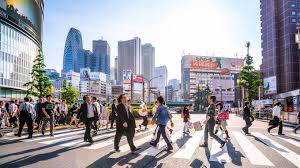

In [8]:
im

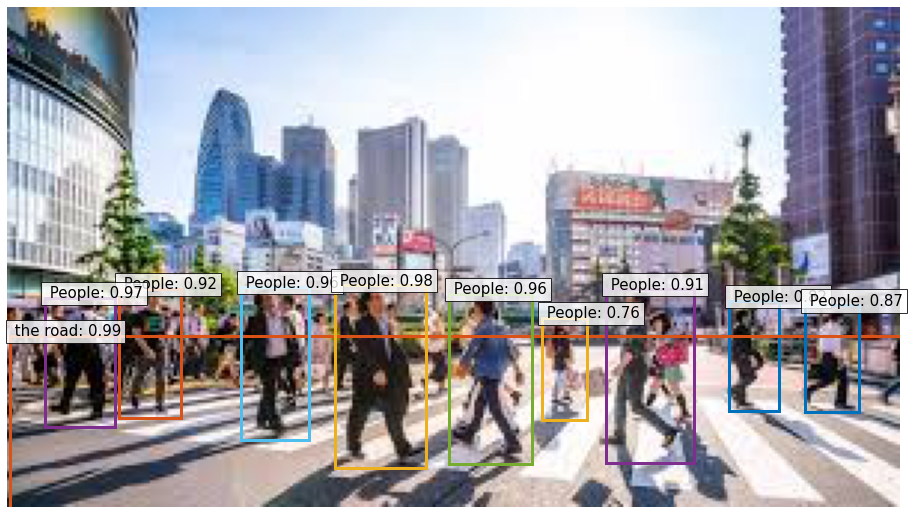

In [16]:
plot_inference(im, "People crossing the road")

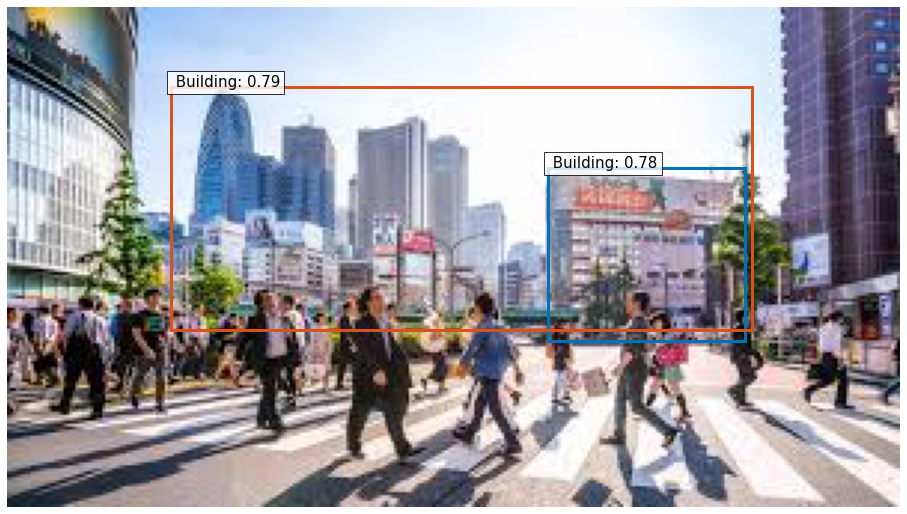

In [17]:
plot_inference(im, "Building in the background")

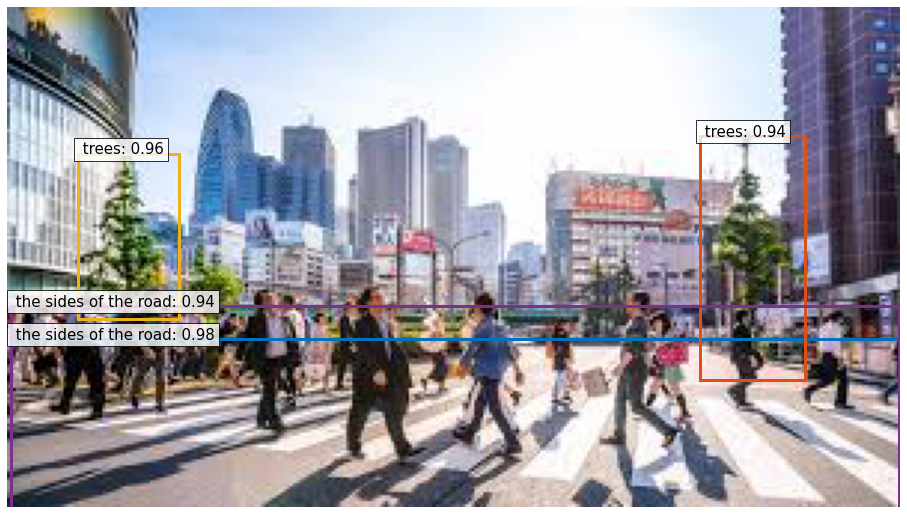

In [18]:
plot_inference(im, "There are trees on the sides of the road")

In [20]:
#Time to finetune the model
#Criterion
matcher = HungarianMatcher()
criterion = SetCriterion(255,matcher,0.1,["labels", "boxes", "cardinality"],0.07).to(device)
#Contrastive_Criterion
contrastive_criterion = ContrastiveCriterion(0.07).to(device)

In [30]:
weight_dict = {"loss_ce": 1, "loss_bbox": 5}
weight_dict["contrastive_loss"] = 0.1
weight_dict["loss_isfinal"] = 1
weight_dict["loss_giou"] = 2
weight_dict["loss_mask"] = 1
weight_dict["loss_dice"] = 1
weight_dict["loss_answer_type"] = 1
weight_dict["loss_answer_cat"] = 1
weight_dict["loss_answer_cat"] = 1 
weight_dict["loss_answer_attr"] = 1 
weight_dict["loss_answer_rel"] = 1 
weight_dict["loss_answer_obj"] = 1 
weight_dict["loss_answer_global"] = 1

In [33]:
model.train()
criterion.train()
contrastive_criterion.train()

ContrastiveCriterion()

In [39]:
#optimizer
param_dicts = [
        {
            "params": [
                p
                for n, p in model.named_parameters()
                if "backbone" not in n and "text_encoder" not in n and p.requires_grad
            ]
        },
        {
            "params": [p for n, p in model.named_parameters() if "backbone" in n and p.requires_grad],
            "lr": 1e-5,
        },
        {
            "params": [p for n, p in model.named_parameters() if "text_encoder" in n and p.requires_grad],
            "lr": 5e-5,
        },
    ]

optimizer = torch.optim.AdamW(param_dicts, lr=1e-4, weight_decay=1e-4)

In [29]:
# I think the codes going to work....BUT ANYONE WILLING TO DO THE MONKEY JOB PREPARING THE DATASET FOR ME TO TRAIN :((((((((((((((((((((
    
# If the code doesnt work, it only need a few minor tweaks to fix the unrealised mistakes




#batch_of_image = ......
#batch_of_caption = .....
#batch_of_positive_map = ...

#memory_cache = model(batch_of_image, batch_of_caption, encode_and_save=True)
#outputs = model(samples, captions, encode_and_save=False, memory_cache=memory_cache)
#loss1 = criterion(outputs, targets, positive_map)
#loss2 = contrastive_criterion(memory_cache["text_pooled_op"], memory_cache["img_pooled_op"])
#total_loss = loss1*weight_dict['loss_ce'] + loss2*weight_dict['contrastive_loss']
#optimizer.zero_grad()
#total_loss.backward()
#torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
#optimizer.step()